# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from warnings import filterwarnings
filterwarnings('ignore')

## Importing Dataset

In [2]:
df = pd.read_excel("datasets/GROUP-14-VALUES_NDVI_LST.xlsx", sheet_name="DATASET", index_col="DATE")

## Data Quality Assessment
The extracted data from GIS software initially contains erroneous values on the LST column. This erroneous data could lead to calculation errors. To mitigate this, we will replace the erroneous values with the value from the previous month.

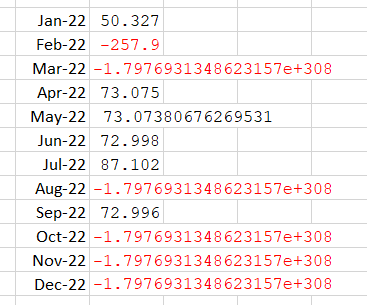


In addition, the NDVI column contains significant outlier exceeding above +/-95% standard deviation. Since a sudden spike in NDVI value is unlikely, we will drop the outlier values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2015-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    108 non-null    float64
 1   LST     101 non-null    float64
 2   TAG     108 non-null    object 
dtypes: float64(2), object(1)
memory usage: 3.4+ KB


## Filling Missing Data
To fill-in the missing data, we use the forward fill method to replace the missing values with the previous month's value. This method is chosen to maintain the continuity of the data.

In [4]:
df.fillna(method="ffill", inplace=True);

## Drop Outliers
To drop the outliers, we will use the Z-score method. The Z-score method is a statistical measurement that tells us how far a point is from the mean of a dataset. We will drop the data points that have a Z-score of more than 3.

In [5]:
# Calculate the mean and standard deviation for LST and NDVI columns
mean_lst = df['LST'].mean()
std_lst = df['LST'].std()
mean_ndvi = df['NDVI'].mean()
std_ndvi = df['NDVI'].std()

# Define the upper and lower bounds for LST and NDVI
upper_bound_lst = mean_lst + 1.96 * std_lst
lower_bound_lst = mean_lst - 1.96 * std_lst
upper_bound_ndvi = mean_ndvi + 1.96 * std_ndvi
lower_bound_ndvi = mean_ndvi - 1.96 * std_ndvi

# Drop the outliers
df = df[(df['LST'] >= lower_bound_lst) & (df['LST'] <= upper_bound_lst)]
df = df[(df['NDVI'] >= lower_bound_ndvi) & (df['NDVI'] <= upper_bound_ndvi)]

## Descriptive Statistics
We will calculate the descriptive statistics of the dataset to understand the distribution of the data. The descriptive statistics include the mean, median, standard deviation, minimum, maximum, and the 25th and 75th percentiles of the dataset.

In [6]:
df[["NDVI", "LST"]].describe()

,NDVI,LST
count,99.000000,99.000000
mean,0.786751,72.817216
std,0.127600,5.344433
min,0.215529,54.785027
25%,0.742880,69.852154
50%,0.804468,72.998222
75%,0.861811,76.672886
max,0.992398,87.102257


## Data Visualization

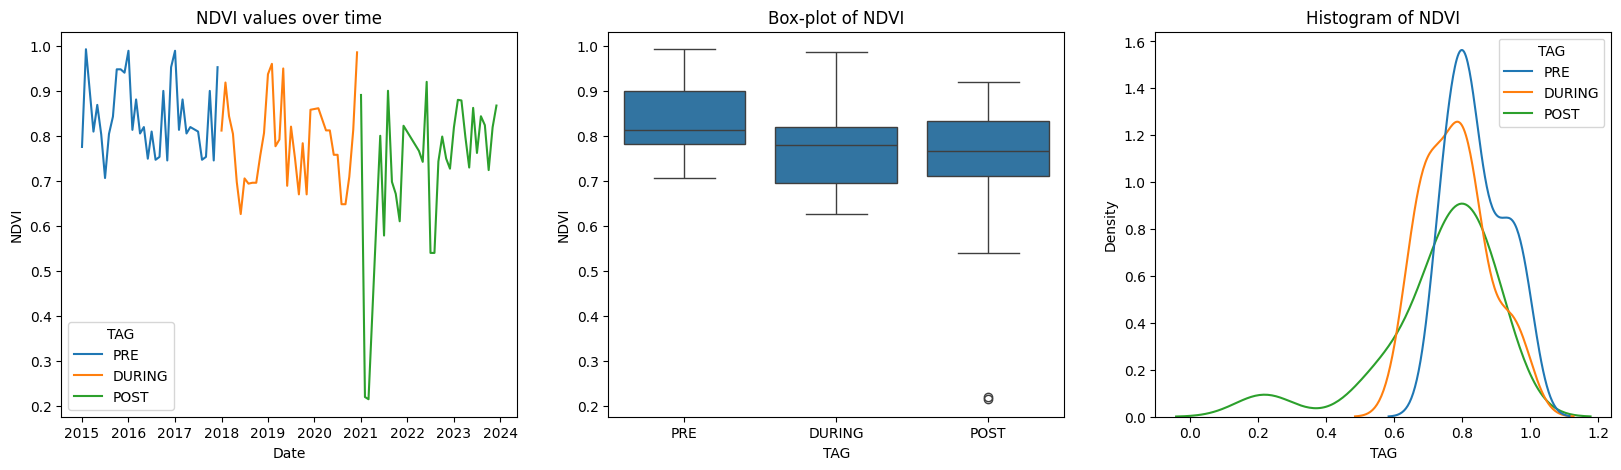

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(df, x=df.index, y=df["NDVI"], hue="TAG", ax=axes[0]).set(
    title="NDVI values over time",
    xlabel="Date",
);

sns.boxplot(df, x="TAG", y="NDVI", ax=axes[1]).set(
    title="Box-plot of NDVI",
    xlabel="TAG",
)

sns.kdeplot(df, x="NDVI", hue="TAG", ax=axes[2]).set(
    title="Histogram of NDVI",
    xlabel="TAG",
);

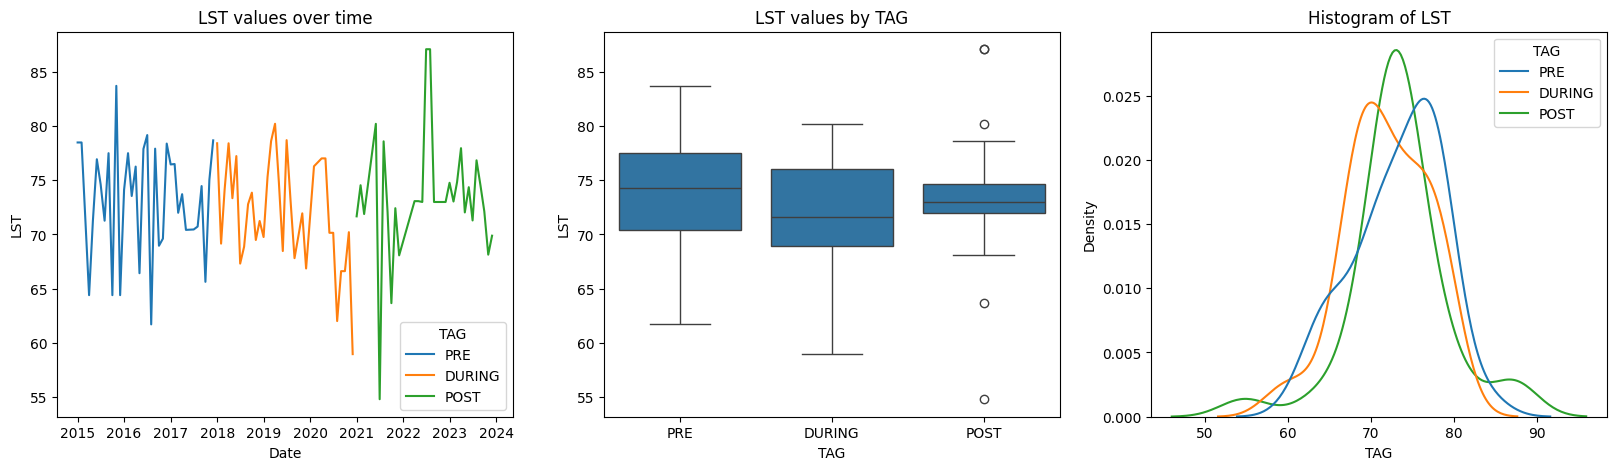

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.lineplot(df, x=df.index, y=df["LST"], hue="TAG", ax=axes[0]).set(
    title="LST values over time",
    xlabel="Date",
);

sns.boxplot(df, x="TAG", y="LST", ax=axes[1]).set(
    title="LST values by TAG",
    xlabel="TAG",
)

sns.kdeplot(df, x="LST", hue="TAG", ax=axes[2]).set(
    title="Histogram of LST",
    xlabel="TAG",
);

## Correlation Analysis
The correlation value of `-0.03 ~ 0.09` between NDVI and LST shows that there is no correlation between pre-kaingin, during kaingin, and post kaingin. This indicates that the NDVI and LST values are not related to each other.

In [9]:
# Custom function to add correlation coefficient
def corrfunc(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(f'Corr: {r:.2f}', xy=(0.1, 0.9), xycoords=ax.transAxes)

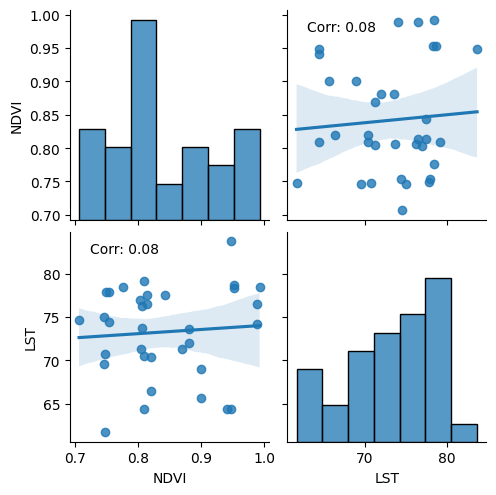

In [10]:
# Create the pairplot with the custom function
g = sns.pairplot(df[df["TAG"] == "PRE"], kind="reg")
g.map_lower(corrfunc);
g.map_upper(corrfunc);

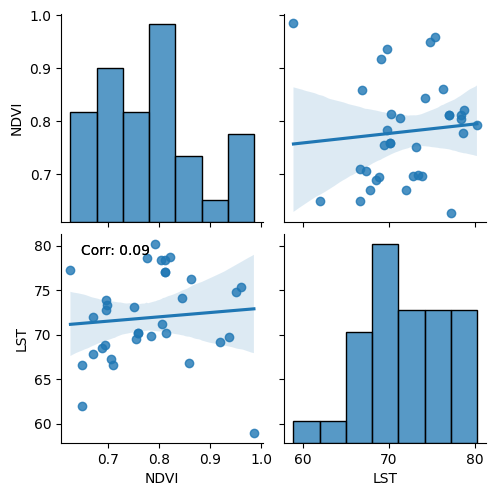

In [11]:
# Create the pairplot with the custom function
g = sns.pairplot(df[df["TAG"] == "DURING"], kind="reg")
g.map_lower(corrfunc);
g.map_lower(corrfunc);

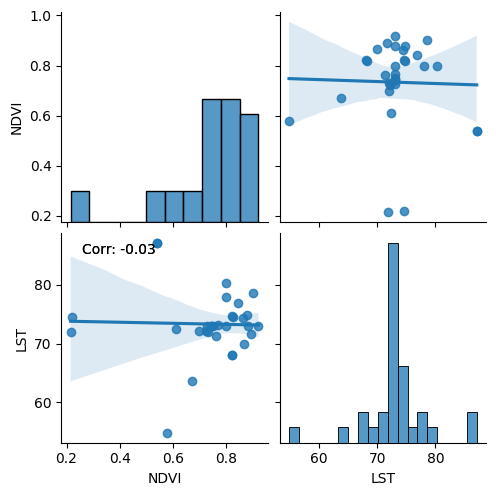

In [12]:
# Create the pairplot with the custom function
g = sns.pairplot(df[df["TAG"] == "POST"], kind="reg")
g.map_lower(corrfunc);
g.map_lower(corrfunc);

## Statistical Analysis

### Normality Check
The D'Agostino normality test will be used to check if the data is normally distributed. The test will return a p-value, which will be used to determine if the data is normally distributed. A p-value of less than 0.05 indicates that the data is not normally distributed. The result of this test shows that both the NDVI and LST data are not normally distributed. This means that we cannot use parametric statistical tests on this data.

In [13]:
import scipy.stats as stats

# Assuming df is your DataFrame and it has 'NDVI' and 'LST' columns
ndvi_data = df['NDVI']
lst_data = df['LST']

# Perform D'Agostino's K-squared test
ndvi_stat, ndvi_p_value = stats.normaltest(ndvi_data)
lst_stat, lst_p_value = stats.normaltest(lst_data)

# Summarize the results in a DataFrame
results = pd.DataFrame({
    'Statistic': [ndvi_stat, lst_stat],
    'p-value': [ndvi_p_value, lst_p_value],
    'Normal Distribution': ['Yes' if ndvi_p_value > 0.05 else 'No', 'Yes' if lst_p_value > 0.05 else 'No']
}, index=['NDVI', 'LST'])

# Print the results DataFrame
results



,Statistic,p-value,Normal Distribution
NDVI,52.096719,4.867895e-12,No
LST,6.180271,4.549579e-02,No


In [14]:
# Analyze and print the analysis
for index, row in results.iterrows():
    if row['Normal Distribution'] == 'Yes':
        print(f"The {index} column is normally distributed (fail to reject H0) with a p-value of {row['p-value']:.4f}.")
    else:
        print(f"The {index} column is not normally distributed (reject H0) with a p-value of {row['p-value']:.4f}.")

The NDVI column is not normally distributed (reject H0) with a p-value of 0.0000.
The LST column is not normally distributed (reject H0) with a p-value of 0.0455.


### Constant Variance Check
The Levene's test will be used to check if the data has constant variance. The test will return a p-value, which will be used to determine if the data has constant variance. A p-value of less than 0.05 indicates that the data does not have constant variance. The result of this test shows that both the NDVI and LST data do not have constant variance. This means that we cannot use parametric statistical tests on this data.

In [15]:
# Perform Levene's test for homogeneity of variances
levene_stat, levene_p_value = stats.levene(ndvi_data, lst_data)

# Summarize the Levene's test results in a DataFrame
variance_results = pd.DataFrame({
    'Statistic': [levene_stat],
    'p-value': [levene_p_value],
    'Equal Variances': ['Yes' if levene_p_value > 0.05 else 'No']
}, index=['NDVI vs LST'])

# Print the variance results DataFrame
variance_results

,Statistic,p-value,Equal Variances
NDVI vs LST,122.147461,2.203861e-22,No


In [16]:
# Analyze and print the variance analysis
if variance_results.loc['NDVI vs LST', 'Equal Variances'] == 'Yes':
    print(f"The variances of NDVI and LST are equal (fail to reject H0) with a p-value of {variance_results.loc['NDVI vs LST', 'p-value']:.4f}.")
else:
    print(f"The variances of NDVI and LST are not equal (reject H0) with a p-value of {variance_results.loc['NDVI vs LST', 'p-value']:.4f}.")

The variances of NDVI and LST are not equal (reject H0) with a p-value of 0.0000.


### Non-Parametric ANOVA

#### Extract Groups
Extract the 'PRE', 'DURING', and 'POST' groups from the 'TAG' column of the DataFrame.

In [17]:
# Extract Groups
# Extract the 'PRE', 'DURING', and 'POST' groups from the 'TAG' column of the DataFrame
pre_group = df[df['TAG'] == 'PRE']
during_group = df[df['TAG'] == 'DURING']
post_group = df[df['TAG'] == 'POST']

#### Perform Kruskal-Wallis Test for NDVI
Use the kruskal() function from scipy.stats to perform the Kruskal-Wallis test for the NDVI values across the three groups. Since p < 0.05, there is strong evidence that at least one group has a different distribution of NDVI compared to the others. We can conduct post hoc tests (e.g., Dunn’s test with Bonferroni correction) to determine which specific groups differ significantly.

In [18]:
from scipy.stats import kruskal

# Perform Kruskal-Wallis Test for NDVI
# Extract NDVI values for each group
ndvi_pre = pre_group['NDVI']
ndvi_during = during_group['NDVI']
ndvi_post = post_group['NDVI']

# Perform the Kruskal-Wallis test
stat, p_value = kruskal(ndvi_pre, ndvi_during, ndvi_post)

# Create a DataFrame with results
results_df = pd.DataFrame({"Test Statistic": [stat], "p-value": [p_value]})

# Return the DataFrame
results_df

,Test Statistic,p-value
0,9.659249,0.00799


#### Perform Post-Hoc Dunn's Test for NDVI
The result of `posthoc_dunn` provides the p-values for pairwise comparisons between the groups "PRE", "DURING", and "POST" for the NDVI column. Here's the interpretation of the results:

- DURING vs POST: p-value = 1.000000
    - There is no significant difference between the "DURING" and "POST" groups for NDVI.
- DURING vs PRE: p-value = 0.031141
    - There is a significant difference between the "DURING" and "PRE" groups for NDVI (p < 0.05).
- POST vs PRE: p-value = 0.016022
    - There is a significant difference between the "POST" and "PRE" groups for NDVI (p < 0.05).
    
In summary, the "PRE" group shows a significant difference in NDVI compared to both the "DURING" and "POST" groups, while there is no significant difference between the "DURING" and "POST" groups.

In [19]:
import scikit_posthocs as sp

# If p < 0.05, perform post hoc tests
if p_value < 0.05:
    # Perform Dunn's test with Bonferroni correction
    posthoc = sp.posthoc_dunn(df, val_col='NDVI', group_col='TAG', p_adjust='bonferroni')
    print(posthoc)

          DURING      POST       PRE
DURING  1.000000  1.000000  0.031141
POST    1.000000  1.000000  0.016022
PRE     0.031141  0.016022  1.000000


#### Perform Kruskal-Wallis Test for LST
Use the kruskal() function from scipy.stats to perform the Kruskal-Wallis test for the LST values across the three groups. Since p > 0.05, we fail to reject the null hypothesis. This suggests that there is no significant difference in LST values across the three groups (pre, during, and post).

In [20]:
# Perform Kruskal-Wallis Test for LST
# Extract LST values for each group
lst_pre = pre_group['LST']
lst_during = during_group['LST']
lst_post = post_group['LST']

# Perform the Kruskal-Wallis test
stat, p_value = kruskal(lst_pre, lst_during, lst_post)

# Create a DataFrame with results
results_df = pd.DataFrame({"Test Statistic": [stat], "p-value": [p_value]})

# Return the DataFrame
results_df

,Test Statistic,p-value
0,1.728003,0.421472
